# Detecting outliers using residuals and STL

In this notebook we show how to identify outliers in time series using STL decomposition and examining the residuals.

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Datasets" from this repo.

## Data Set Synopsis

The timeseries is between January 1992 and Apr 2005.

It consists of a single series of monthly values representing sales volumes. 

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import STL

sns.set_context("talk")

# Load data

In [18]:
# Load retail sales dataset with the artificially added outliers
df = pd.read_csv(
    "../Datasets/example_retail_sales_with_outliers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

# Plot the data to visually inspect any outliers

Text(0.5, 0, 'Time')

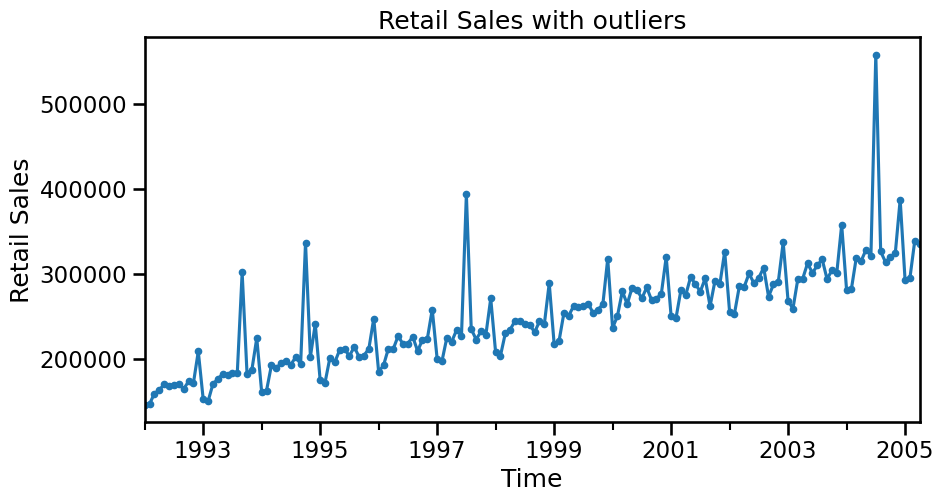

In [19]:
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_title("Retail Sales with outliers")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

In previous examples we de-seasonalised the data before applying our outlier detection methods. We shall see that we do not need to do this with STL decomposition. This is because STL decomposition breaks up a time series directly into a seasonality, trend, and residual component. We can examine that residual component for the purpose of identifying outliers directly.

# Identifying outliers from the residuals of STL decomposition

If the time series has a strong seasonal component then STL decomposition can be used to compute the expected value $\hat{y}_t$. STL decomposition provides an estimate of a trend component, seasonal component, and a residual component. The residuals are the original time series subtracted by the trend and seasonal component. The residuals from STL decomposition can be used to identify outliers.

The expected value $\hat{y}_t$ is computed as the trend and seasonal components of the STL:

$$\hat{y}_t = trend_t + seasonal_t$$

where $seasonal_t$ and $trend_t$ are the values of the seasonal and trend component obtained by the STL decomposition at time $t$.

The residuals are computed: $e_t = y_t - \hat{y}_t$
and the quartiles and interquartile range of the residuals are calculated across the whole time series.

The threshold is defined by the distance from the lower and upper quartiles of the residuals and does not depend on time:

$$\delta_{upper} = Q_3 + \alpha \times IQR$$
$$\delta_{lower} = Q_1 - \alpha \times IQR$$

$\alpha=1.5$ is a typical choice, however this can be adjusted depending on how sensitive you want the outlier detection to be.

A data point is an outlier if:
$$e_t = y_t - \hat{y}_t > \delta_{upper}$$
$$e_t = y_t - \hat{y}_t < \delta_{lower}$$


We shall use the data **with** the seasonal component for this method.

In [20]:
df_ = df.copy()

In [21]:
# Apply STL decomposition
# Setting the robust parameter to true means that a fitting method is used
# that is more robust to outliers.
column_to_decompose = df_["y"] 
res = STL(column_to_decompose,robust=True).fit()

We now plot the decomposition to inspect that it is reasonable.

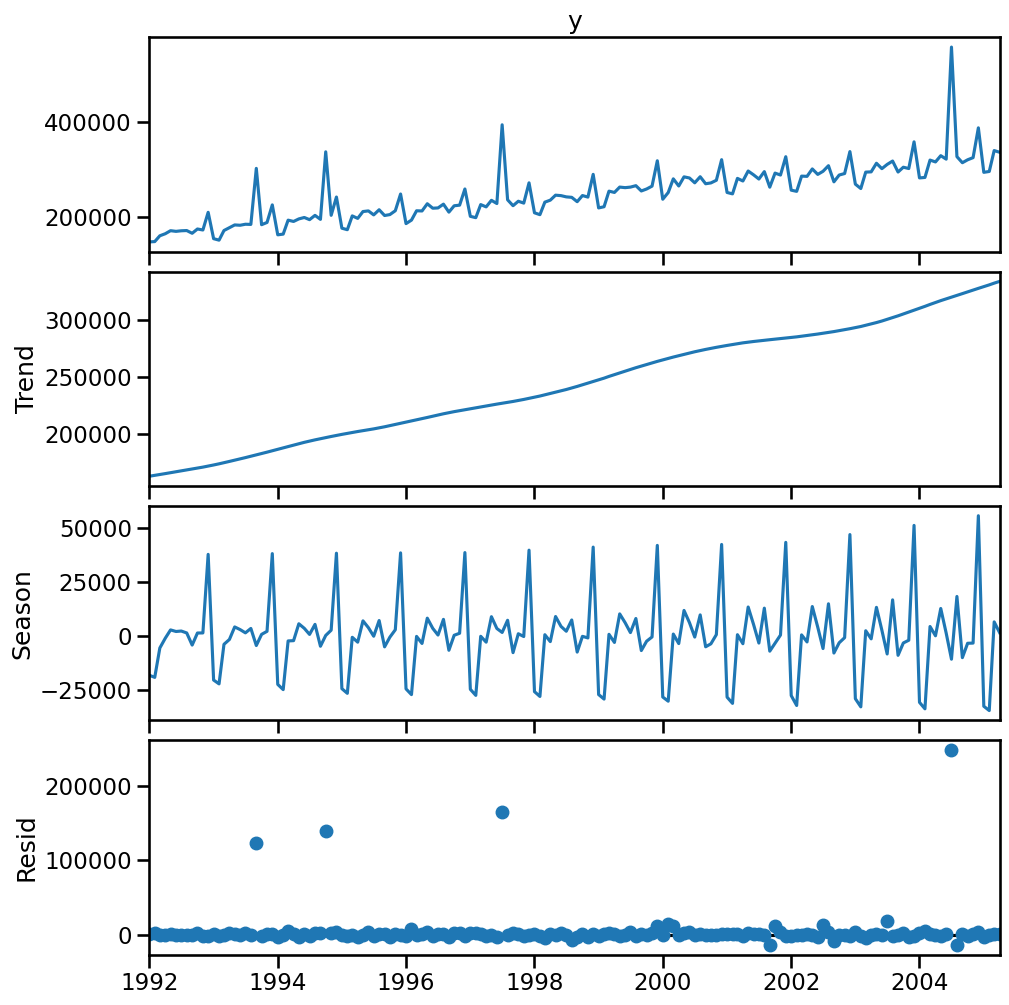

In [22]:
plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
res.plot();

Now, we can extract the residuals from the STL decomposition, and find the outliers.

In [23]:
# Compute residuals
df_["residual"] = res.resid

# Compute inter-quartile range
Q1 = df_["residual"].quantile(0.25)
Q3 = df_["residual"].quantile(0.75)
IQR = Q3 - Q1

# Apply 1.5 IQR as a threshold to identify outliers
factor = 1.5
df_["lower"] = Q1 - factor * IQR
df_["upper"] = Q3 + factor * IQR
df_["is_outlier"] = (df_["residual"] < (Q1 - factor * IQR)) | (
    df_["residual"] > (Q3 + factor * IQR)
)

df_.head()

,y,residual,lower,upper,is_outlier
ds,,,,,
1992-01-01,146376.0,984.653087,-5692.104751,5815.647076,False
1992-02-01,147079.0,1922.820053,-5692.104751,5815.647076,False
1992-03-01,159336.0,-233.773804,-5692.104751,5815.647076,False
1992-04-01,163669.0,-1218.191626,-5692.104751,5815.647076,False
1992-05-01,170068.0,548.978491,-5692.104751,5815.647076,False


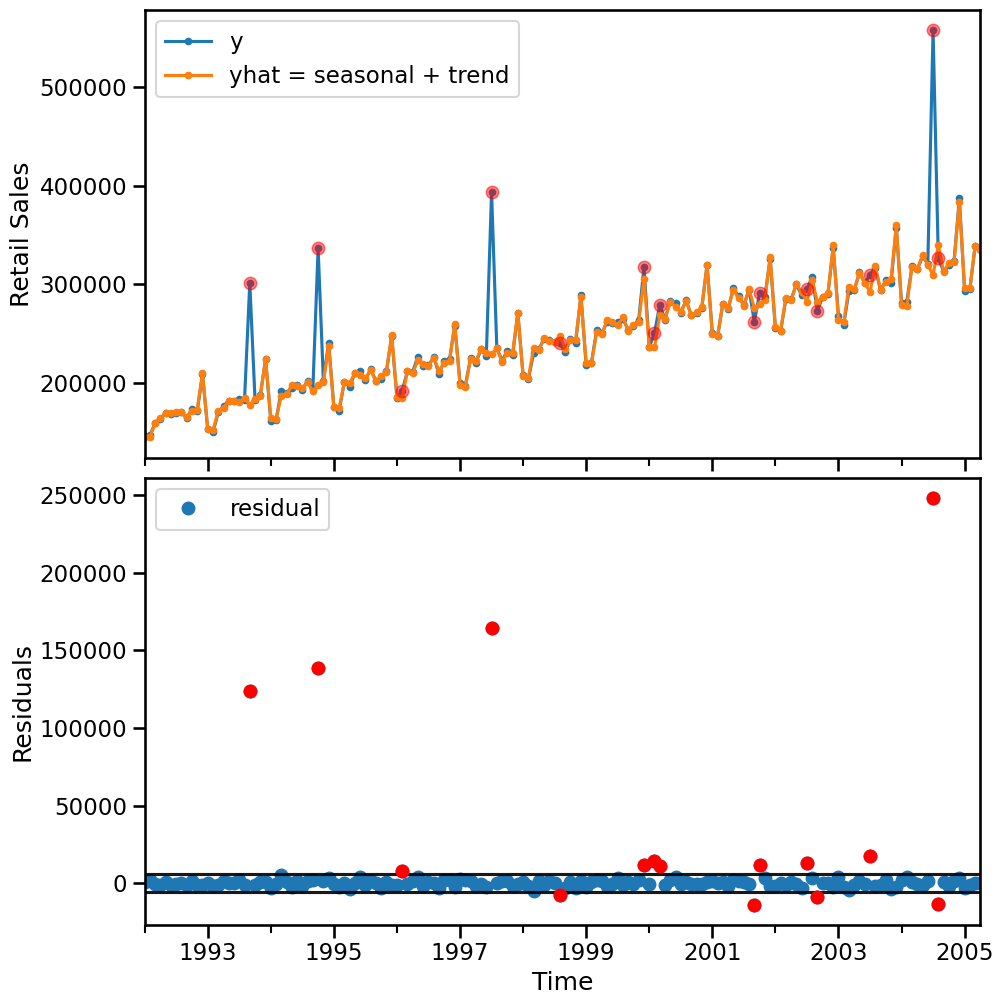

In [24]:
# Plot time series
df_["yhat = seasonal + trend"] = res.seasonal + res.trend

fig, ax = plt.subplots(nrows=2, figsize=[10, 10], sharex=True)
df_.plot(y=["y", "yhat = seasonal + trend"], marker=".", ax=ax[0])
df_["residual"] = df_["residual"]

# Plot residuals
df_.plot(y=["residual"], ax=ax[1], marker="o", linestyle="")
df_.plot(y=["upper", "lower"], ax=ax[1], color="k", legend=None, alpha=0.9)

# If any data points are identified as an outlier, plot them
if df_["is_outlier"].any():
    df_["y"].loc[df_["is_outlier"]].plot(
        marker="o", color="r", ax=ax[0], legend=None, linestyle="", alpha=0.5
    )
    df_["residual"].loc[df_["is_outlier"]].plot(
        marker="o", color="r", ax=ax[1], legend=None, linestyle=""
    )

ax[0].set_ylabel("Retail Sales")
ax[1].set_ylabel("Residuals")

ax[1].set_xlabel("Time")
plt.tight_layout()

We can also visualise the residuals for outliers using a histogram and box plot. This also allows us to check that the data is approximately normal.

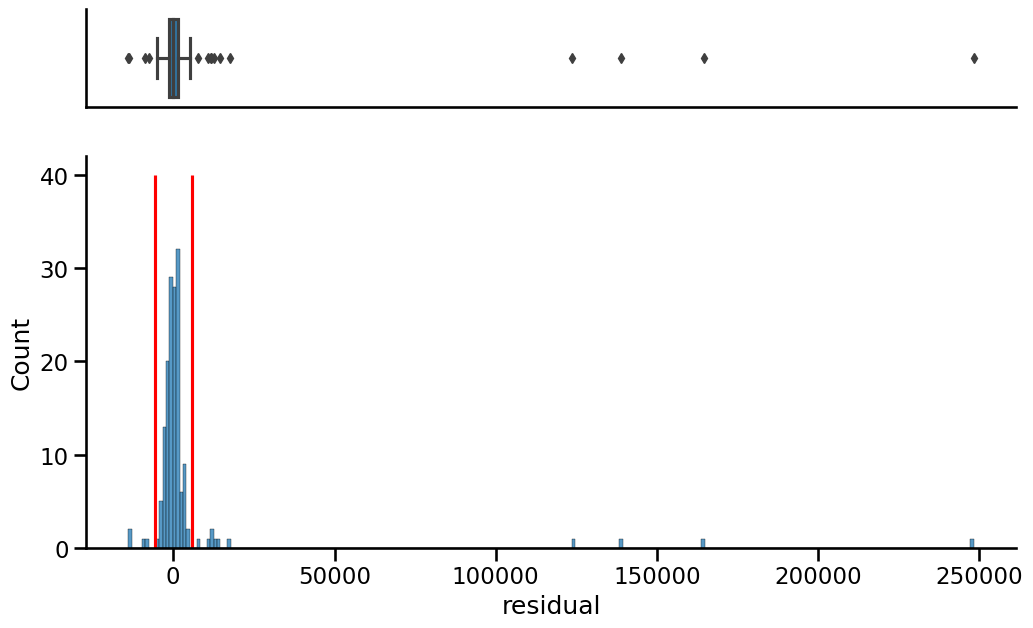

In [25]:
f, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.20, 0.80)}, figsize=[12, 7]
)
sns.boxplot(x=df_["residual"], ax=ax_box)
sns.histplot(x=df_["residual"], ax=ax_hist)

ax_box.axes.get_xaxis().set_visible(False)
ax_box.axes.get_yaxis().set_visible(False)

ax_hist.vlines(Q1 - factor * IQR, 0, 40, color="r")
ax_hist.vlines(Q3 + factor * IQR, 0, 40, color="r")
sns.despine()
plt.show()

As we can see the residual method is much more sensitive and identified even smaller fluctuations in the data. The outliers are much clearer in the residual plot. To make the methods less sensitive, a simple solution here would be to adjust threshold.

# Removing the outliers

Once the outliers are identified and a choice is made to remove them they can be imputed using missing value methods or using the values from the estimation methods. 

As an example we shall use linear interpolation.

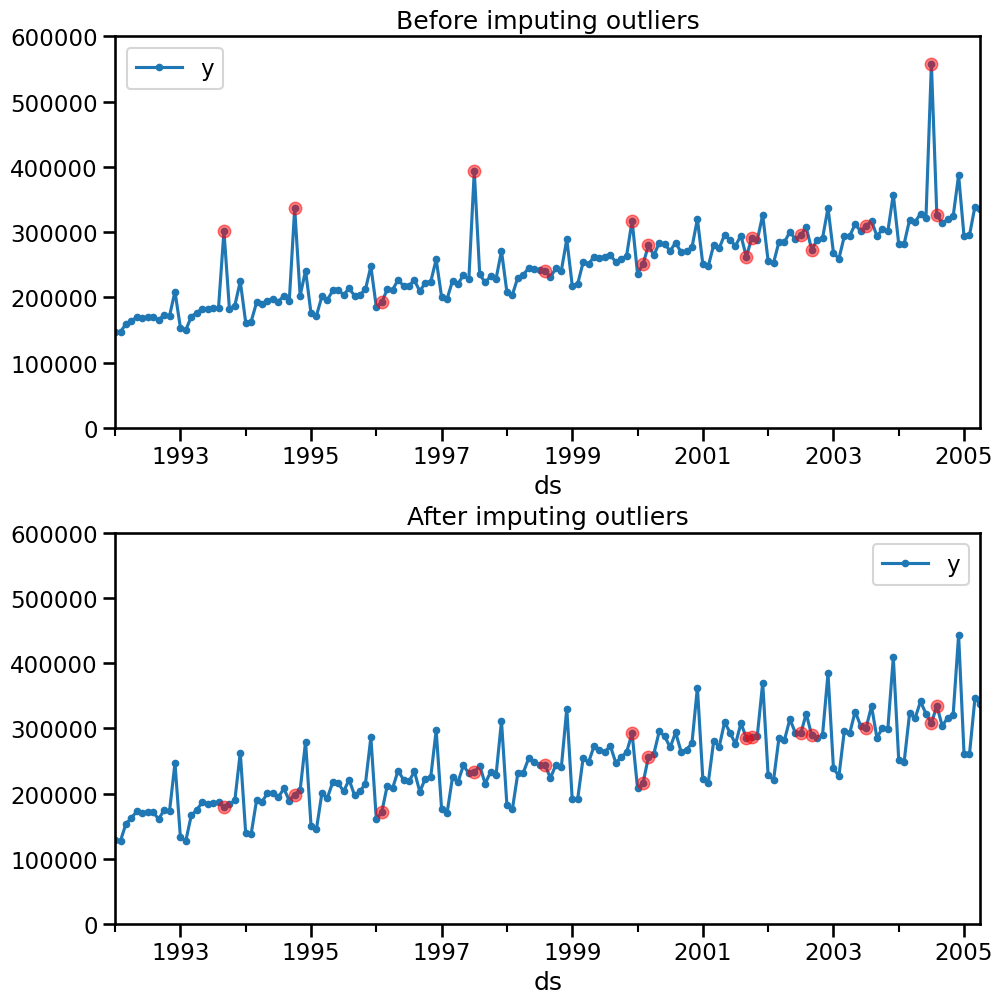

In [26]:
# Set outliers to NaN
df_.loc[df_["is_outlier"], "y"] = np.NaN

# Apply linear interpolation
df_.interpolate(method="linear", inplace=True)

# Add the seasonality extracted from STL back to deseasoned data
df_["y"] = df_["y"] + res.seasonal

# Plot the data and location of the identified outliers from the rolling median method
fig, ax = plt.subplots(nrows=2, figsize=[10, 10])
df.plot(y="y", marker=".", title="Before imputing outliers", ax=ax[0])
df[df_["is_outlier"]]["y"].plot(
    marker="o", color="r", ax=ax[0], legend=None, linestyle="", alpha=0.5
)
df_.plot(y=["y"], marker=".", title="After imputing outliers", ax=ax[1])
df_[df_["is_outlier"]]["y"].plot(
    marker="o", color="r", ax=ax[1], legend=None, linestyle="", alpha=0.5
)
ax[0].set_ylim([0, 600000])
ax[1].set_ylim([0, 600000])

plt.tight_layout()